In [78]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import pickle
import nltk
import os
import sklearn.manifold
from collections import Counter
from nltk.cluster import kmeans, cosine_distance
from unidecode import unidecode
import re

In [5]:
nlp = spacy.load('es_core_news_sm', vectors=False, entity=False)

In [115]:
dataset= ""
p = 0
for i in range(28):
    if i+1 < 10:
        path = "Periodico_castella/text_spa/2004-05-0"+str(i+1)+"/"
    else:
        path = "Periodico_castella/text_spa/2004-05-"+str(i+1)+"/"
    for filename in os.listdir(path):
        if "19" in filename:
            continue
        text_file = open(path+filename, "r", encoding='ISO-8859-1')
        text = text_file.read()
        if len(text) > 50:
            p = p +1
            dataset += text
        text_file.close()

text = nltk.sent_tokenize(dataset.replace("\n", " --- ").replace("---",".").replace(" .",""))
with  open("periodico", "w", encoding='ISO-8859-1') as f:
    f.write(dataset.replace("\n", " --- ").replace("---",".").replace(" .",""))

In [43]:
def parse_tags(word):
    tags = word.tag_[len(word.pos_) + 2:]
    tags = tags.split("|")
    return tags
spacy_stopwords = spacy.lang.es.stop_words.STOP_WORDS

In [101]:
%%time
doc= []
dicc = {}
lista = []
word_id = 0
words = []
threshold_w = 50
threshold_c = 50
for sent in text:
    if len(sent) > 30:
        doc = nlp(sent)
        for word in doc:
            if word in spacy_stopwords:
                continue
            words.append(word)
            w = word.lemma_
            if not word.is_alpha or str.isdigit(w):
                continue
            if not w in dicc:
                features = {}
            else:
                features = dicc[w]
            
        
            pos = "POS__" + word.pos_
            if not pos in features:
                features[pos] = 0
            features[pos] += 1

            dep = "DEP__" + word.dep_
            if not dep in features:
                features[dep] = 0
            features[dep] += 1

            tags = parse_tags(word)
            for tag in tags:
                if not tag in features:
                    features[tag] = 0
                features[tag] += 1
                
            for wod in doc:
                wod_lemma = wod.lemma_
                if wod.is_alpha:
                    if str.isdigit(wod_lemma):
                        wod_lemma = "NUM__"
                    if not wod_lemma in features:
                        features[wod_lemma] = 1
                    features[wod_lemma] += 1


            word_id += 1

            dicc[w] = features

CPU times: user 2min 21s, sys: 718 ms, total: 2min 22s
Wall time: 2min 24s


In [102]:
threshold_w = 10
tail_off = dict(filter(lambda elem: elem[1]["count"] >= threshold_w,dicc.items()))

In [103]:
for d in tail_off:
    #del dicc[d]["count"]
    banned = []
    for word in tail_off[d]:
        if "__" in word or "=" in word or word == '_':
            continue
        if dicc[word][word] <= 1:
            banned.append(word)
    for word in banned:
        del dicc[d][word]

In [117]:
for d in tail_off:
    #del dicc[d][d]
    continue
features = []
key_words = {}
wid = 0
for d in tail_off:
    if len(d) > 0:
        key_words[d] = wid
        wid += 1
        features.append(dicc[d])

In [105]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=False)
matrix = v.fit_transform(features)

In [106]:
matrix_normed = matrix / matrix.max(axis=0)
variances = np.square(matrix_normed).mean(axis=0) - np.square(matrix_normed.mean(axis=0))
threshold_v = 0.001
red_matrix = np.delete(matrix_normed, np.where(variances < threshold_v), axis=1)

In [107]:
%%time
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
matrix_dicc2d = tsne.fit_transform(red_matrix)

CPU times: user 1min 35s, sys: 414 ms, total: 1min 35s
Wall time: 1min 38s


In [108]:
pointsspacy = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, matrix_dicc2d[key_words[word]])
            for word in key_words
        ]
    ],
    columns=["word", "x", "y"]
)

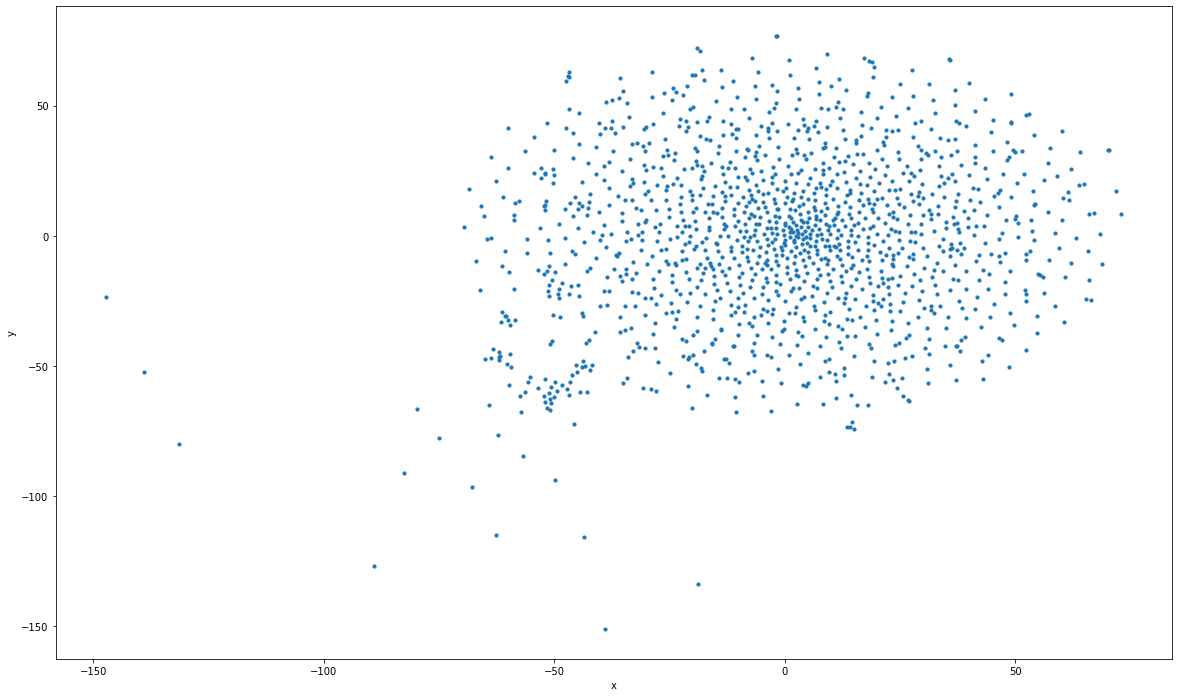

In [109]:
pointsspacy.plot.scatter("x", "y", s=10, figsize=(20, 12))


In [110]:
def clustering(k):
    clusterer = kmeans.KMeansClusterer(k, cosine_distance, avoid_empty_clusters=True)
    clusters = clusterer.cluster(red_matrix, True)
    return clusters

In [111]:
%%time
c50 =  clustering(100)

CPU times: user 4min 57s, sys: 1.22 s, total: 4min 58s
Wall time: 5min 3s


In [112]:
pointscluster = pd.DataFrame(
    [
        (word, coords[0], coords[1], cluster)
        for word, coords, cluster in [
            (word, matrix_dicc2d[key_words[word]], c50[key_words[word]])
            for word in key_words
        ]
    ],
    columns=["word", "x", "y", "c"]
)

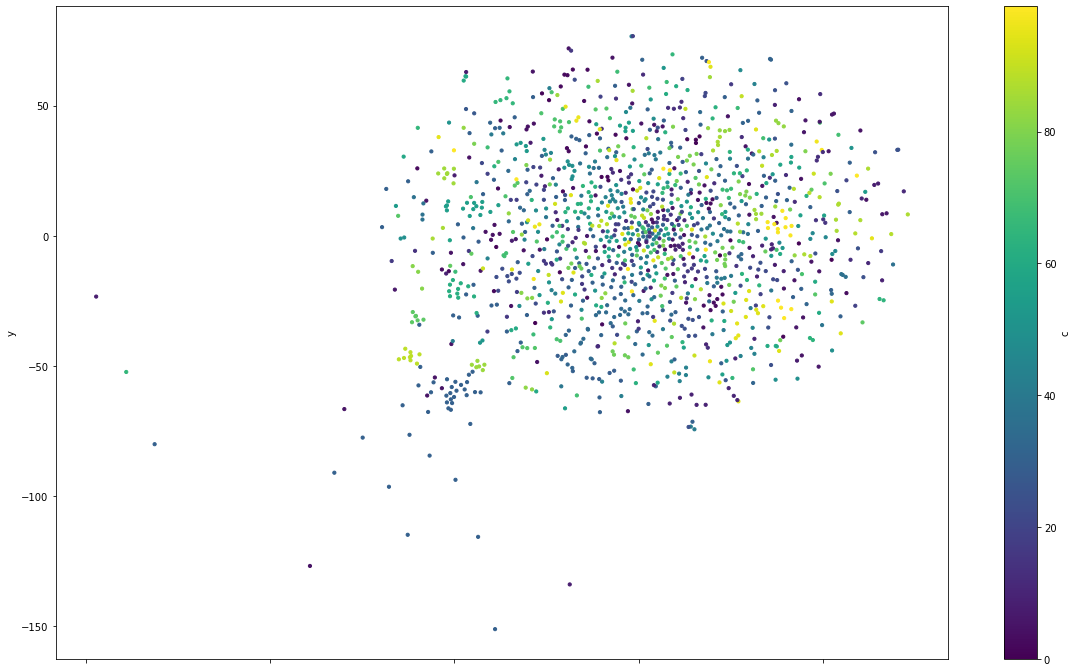

In [113]:
pointscluster.plot.scatter(x='x', y='y', c='c', cmap='viridis', s=10, figsize=(20, 12))

In [114]:
printer_dic={}
for word in key_words:
    if c50[key_words[word]] not in printer_dic:
        printer_dic[c50[key_words[word]]] = [word]
    else:
        printer_dic[c50[key_words[word]]].append(word)
printer = [word for word in key_words if c50[key_words[word]] == c50[key_words["guerra"]]]
for key in sorted(printer_dic.keys()) :
    print(key , " :: " , printer_dic[key])

0  ::  ['avanzar', 'recorrer', 'profesional', 'anual']
1  ::  ['situación', 'reclamar', 'británico', '\ufeff1', 'Le', 'cifrar', 'portugués', 'autoridad', 'origen', 'Londres', 'italiano', 'detener', 'fichaje']
2  ::  ['guerra', 'mujer', 'músico', 'semana', 'seriar', 'atrás', 'personaje', 'espaciar', 'actor', 'show', 'contar', 'filmar', 'estrellar', 'musical', 'viejo', 'género', 'éxito', 'violencia', 'practicar']
3  ::  ['crear', 'publicar', 'isla', 'humano', 'lector', 'escribir', 'novelar', 'memoria', 'escritor', 'libro', 'editorial', 'referir', 'aspecto', 'facilitar', 'Dos', 'representante', 'describir', 'sexo']
4  ::  ['disco', 'visión', 'escena', 'escenario', 'merecer', 'repartir', 'tocar', 'número', 'luego', 'Sólo', 'echar', 'cualquiera', 'confesar', 'concertar']
5  ::  ['si', 'Tras', 'ser', 'ir', 'realizar', 'llevar', 'trabajar', 'hacer', 'quedar', 'querer', 'disponer', 'reducir', 'Estado', 'paso', 'tener', 'asegurar', 'pero', 'presentar', 'decir', 'retirar', 'donde', 'Cuando', 've

In [314]:
def plot_region(x_bounds, y_bounds):
    slice = pointsspacy[
        (x_bounds[0] <= pointsspacy.x) &
        (pointsspacy.x <= x_bounds[1]) & 
        (y_bounds[0] <= pointsspacy.y) &
        (pointsspacy.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter(x='x', y='y', s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

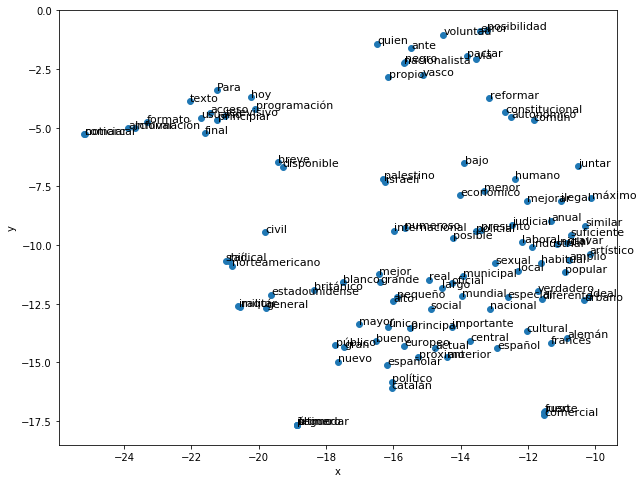

In [315]:
plot_region(x_bounds=(-240, -10), y_bounds=(-220, 0))